# [RSNA 2023 Abdominal Trauma Detection](https://www.kaggle.com/competitions/rsna-2023-abdominal-trauma-detection)

![](https://www.kaggle.com/competitions/52254/images/header)

# Idea:
* we will classify `Detect and classify traumatic abdominal injuries` from CT scans.
* We'll maximize the `binary_cross_entropy` score using as it similar to `log_loss`. ('log_loss'가 현재 데이터셋의 공식 성능 평가 지표)

# Install Libraries

In [2]:
!pip install -q keras-cv-attention-models
!pip install -qU scikit-learn
!pip install -q seaborn

# Import Libraries

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # to avoid too many logging messages
import pandas as pd, numpy as np, random, shutil
import sklearn
import matplotlib.pyplot as plt
import yaml

from glob import glob
from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, StratifiedGroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import torch
from torchvision import transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split

from PIL import Image
from IPython import display as ipd
from IPython.display import display
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Seed for reproducibility

In [4]:
def seeding(SEED):
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print('seeding done!!!')

seeding(42)

seeding done!!!


In [5]:
BASE_PATH = f'/kaggle/input/rsna-atd-512x512-png-v2-dataset' #이미 png 파일로 변경된 dataset

# Meta Data

The `train.csv` file contains the following meta information:

- `patient_id`: A unique ID code for each patient.
- `series_id`: A unique ID code for each scan.
- `instance_number`: The image number within the scan. The lowest instance number for many series is above zero as the original scans were cropped to the abdomen.
- `[bowel/extravasation]_[healthy/injury]`: The two injury types with binary targets.
- `[kidney/liver/spleen]_[healthy/low/high]`: The three injury types with three target levels.
- `any_injury`: Whether the patient had any injury at all.


In [6]:
# train
df = pd.read_csv(f'{BASE_PATH}/train.csv')
df['image_path'] = f'{BASE_PATH}/train_images'\
                    + '/' + df.patient_id.astype(str)\
                    + '/' + df.series_id.astype(str)\
                    + '/' + df.instance_number.astype(str) +'.png'
df = df.drop_duplicates()
print('Train:')
display(df.head(2))

# test
test_df = pd.read_csv(f'{BASE_PATH}/test.csv')
test_df['image_path'] = f'{BASE_PATH}/test_images'\
                    + '/' + test_df.patient_id.astype(str)\
                    + '/' + test_df.series_id.astype(str)\
                    + '/' + test_df.instance_number.astype(str) +'.png'
test_df = test_df.drop_duplicates()
print('\nTest:')
display(test_df.head(2))

Train:


,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,...,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name,image_path,width,height
0,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,362,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512
1,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,363,Active_Extravasation,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,512,512



Test:


,image_path,patient_id,series_id,instance_number,width,height
0,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,63706,39279,30,512,512
1,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,50046,24574,30,512,512


In [7]:
print('train_files:',df.shape[0])
print('test_files:',test_df.shape[0])

train_files: 12029
test_files: 3


# Class Dependency

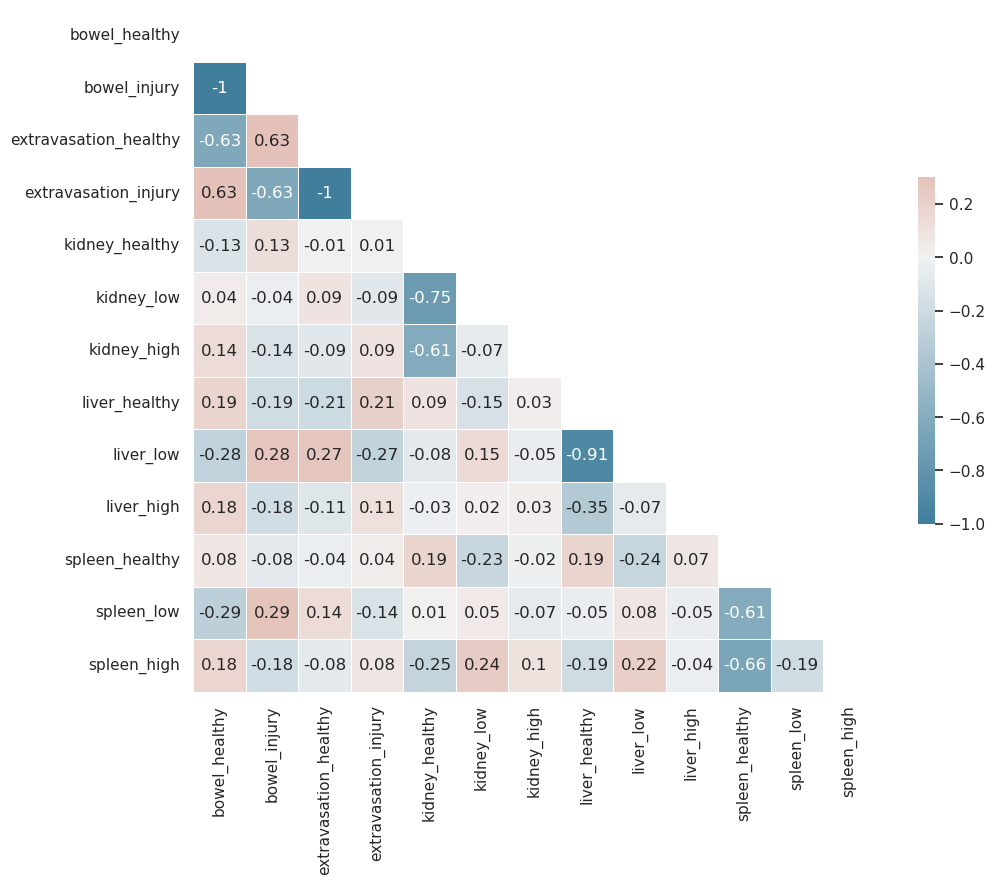

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Compute the correlation matrix
corr = df[df.columns[1:14]].corr().round(2)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show();

# Build CustomDataset & Save

In [9]:
img_list = df["image_path"].tolist()

In [10]:
target_col  = ["bowel_injury", "extravasation_injury", "kidney_healthy", "kidney_low",
                   "kidney_high", "liver_healthy", "liver_low", "liver_high",
                   "spleen_healthy", "spleen_low", "spleen_high"]

In [11]:
labels_df = df[target_col]
labels_df

,bowel_injury,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high
0,0,1,0,1,0,1,0,0,0,0,1
1,0,1,0,1,0,1,0,0,0,0,1
2,0,1,0,1,0,1,0,0,0,0,1
3,0,1,0,1,0,1,0,0,0,0,1
4,0,1,0,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
13010,0,1,1,0,0,1,0,0,1,0,0
13011,0,1,1,0,0,1,0,0,1,0,0
13012,0,1,1,0,0,1,0,0,1,0,0
13013,0,1,1,0,0,1,0,0,1,0,0


In [12]:
class CustomCaptchaDataset(torch.utils.data.Dataset):
    def __init__(self, img_list, labels_df, transform=None):
        self.img_list = img_list
        self.transform = transform
        self.labels_df = labels_df

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        image_path = self.img_list[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels_df.iloc[idx].tolist()

        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label)

        return image, label

In [13]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)), # 데이터의 크기를 동일하게 맞춰주기
    transforms.ToTensor(), # 각 픽셀의 값을 [0,1]
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [14]:
# 데이터셋 객체 생성
train_dataset = CustomCaptchaDataset(img_list, labels_df, transform=transform_train)

In [15]:
import pickle

# Save the paths and labels from your dataset
dataset_info = {
    'img_list': train_dataset.img_list,
    'labels_df': train_dataset.labels_df
}

# Save the dataset info to a file using pickle
with open('custom_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_info, f)

In [16]:
with open('custom_dataset.pkl', 'rb') as f:
    dataset_info = pickle.load(f)

# Create a new instance of your custom dataset using the loaded info
loaded_dataset = CustomCaptchaDataset(
    img_list=dataset_info['img_list'],
    labels_df=dataset_info['labels_df'],
    transform=transform_train
)

In [17]:
# 데이터셋 정보 로드
train_dataloader = DataLoader(loaded_dataset, batch_size=64, shuffle=True)
train_dataloader

In [18]:
for (inputs, labels) in train_dataloader:
    print(inputs.shape) # [batch_size, channel, width, height]
    print(labels.shape) # [batch_size, digits_size]

    break

torch.Size([64, 3, 256, 256])
torch.Size([64, 11])


# Augmentation & Split Dataset

In [19]:
img_list=dataset_info['img_list']
labels_df=dataset_info['labels_df']

In [20]:
from sklearn.model_selection import train_test_split
train_data_list, val_data_list, train_labels, val_labels = train_test_split(
    img_list, labels_df, test_size=0.2, random_state=42
)

In [21]:
# 학습 데이터 데이터 증진(data augmentation)
transform_train = transforms.Compose([
    transforms.Resize((256, 256)), # 데이터의 크기를 동일하게 맞춰주기
    transforms.RandomHorizontalFlip(), # 데이터 증진
    transforms.ToTensor(), # 각 픽셀의 값을 [0, 1]
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

transform_val = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [22]:
train_dataset = CustomCaptchaDataset(train_data_list, train_labels, transform=transform_train)
val_dataset = CustomCaptchaDataset(val_data_list, val_labels, transform=transform_val)

# DataLoader for training and validation datasets
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

학습 데이터 개수: 9623


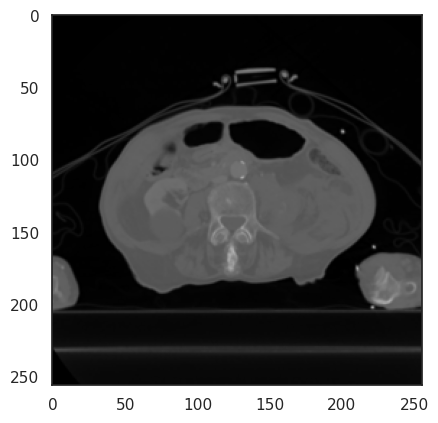

tensor([0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0])


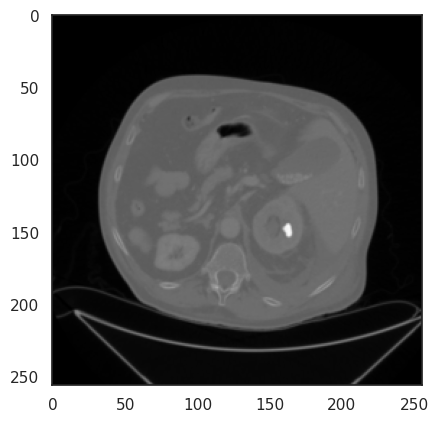

tensor([0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0])


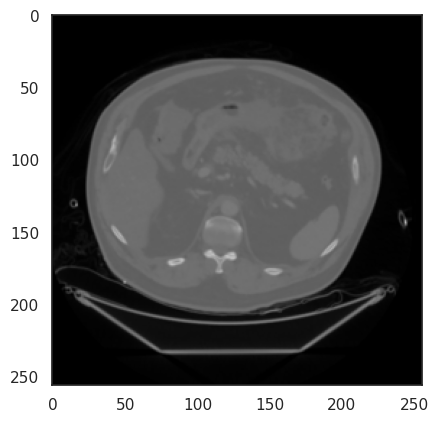

tensor([1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0])


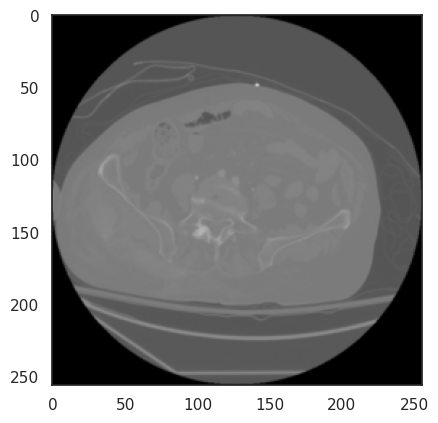

tensor([0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0])


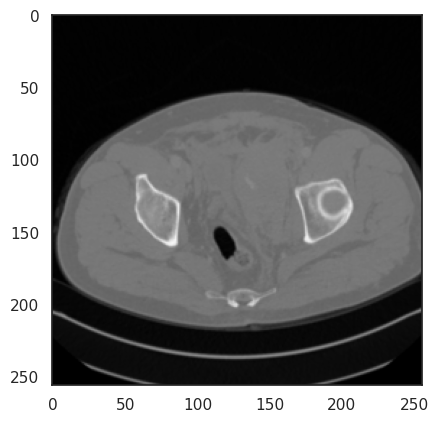

tensor([0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0])


In [23]:
def imshow(input):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    plt.imshow(input)
    plt.show()

print(f"학습 데이터 개수: {len(train_dataset)}")

iterator = iter(train_dataloader)
imgs, labels = next(iterator)

for i in range(5):
    imshow(imgs[i])
    print(labels[i])

# Build Model & Training

In [40]:
import time

def train():
    model.train()
    total_train_loss = 0
    train_correct_bce1 = 0
    train_correct_bce2 = 0
    train_correct_ce1 = 0
    train_correct_ce2 = 0
    train_correct_ce3 = 0
    train_total = 0

    for step, (images, labels) in enumerate(train_dataloader):
        images = images.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()

        outputs = model(images)

        # 정확도 계산
        predicted_bce1 = (outputs[:, 0:1] > 0).float()
        predicted_bce2 = (outputs[:, 1:2] > 0).float()
        train_correct_bce1 += (predicted_bce1 == labels[:, 0:1].float()).sum().item()
        train_correct_bce2 += (predicted_bce2 == labels[:, 1:2].float()).sum().item()
        predicted_ce1 = torch.argmax(outputs[:, 2:5], dim=1)
        predicted_ce2 = torch.argmax(outputs[:, 5:8], dim=1)
        predicted_ce3 = torch.argmax(outputs[:, 8:11], dim=1)
        train_total += labels.size(0)
        train_correct_ce1 += (predicted_ce1 == torch.argmax(labels[:, 2:5], dim=1)).sum().item()
        train_correct_ce2 += (predicted_ce2 == torch.argmax(labels[:, 5:8], dim=1)).sum().item()
        train_correct_ce3 += (predicted_ce3 == torch.argmax(labels[:, 8:11], dim=1)).sum().item()

        accuracy_bce1 = train_correct_bce1 / train_total
        accuracy_bce2 = train_correct_bce2 / train_total
        accuracy_ce1 = train_correct_ce1 / train_total
        accuracy_ce2 = train_correct_ce2 / train_total
        accuracy_ce3 = train_correct_ce3 / train_total
        
        # 손실 계산
        loss_bce = bce_loss(outputs[:, 0:1], labels[:, 0:1].float())  # Binary Cross Entropy
        loss_bce2 = bce_loss(outputs[:, 1:2], labels[:, 1:2].float())  # Binary Cross Entropy
        loss_ce1 = ce_loss(outputs[:, 2:5], torch.argmax(labels[:, 2:5], dim=1))
        loss_ce2 = ce_loss(outputs[:, 5:8], torch.argmax(labels[:, 5:8], dim=1))
        loss_ce3 = ce_loss(outputs[:, 8:11], torch.argmax(labels[:, 8:11], dim=1))
        total_loss = loss_bce + loss_bce2 + loss_ce1 + loss_ce2 + loss_ce3

        total_train_loss += total_loss.item()    
        total_loss.backward()
        optimizer.step()

        if step % log_step == 0:
            elapsed_time = time.time() - start_time
            print(f"Epoch [{epoch}/{num_epochs}], Step [{step}/{len(train_dataloader)}], "
                  f"Loss: {total_loss.item():.4f}, Acc1: {accuracy_bce1:.4f}, Acc2: {accuracy_bce2:.4f}, Acc3: {accuracy_ce1:.4f}, Acc4: {accuracy_ce2:.4f}, Acc5: {accuracy_ce3:.4f}, "
                  f"Elapsed Time: {elapsed_time:.2f} seconds")
            
    return total_loss, [accuracy_bce1, accuracy_bce2, accuracy_ce1, accuracy_ce2, accuracy_ce3]

In [44]:
def validate():
    
    model.eval()
    total_val_loss = 0
    val_correct_bce1 = 0
    val_correct_bce2 = 0
    val_correct_ce1 = 0
    val_correct_ce2 = 0
    val_correct_ce3 = 0
    val_total = 0

    for step, (images, labels) in enumerate(val_dataloader):
        images = images.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()

        outputs = model(images)

        # 정확도 계산
        predicted_bce1 = (outputs[:, 0:1] > 0).float()
        predicted_bce2 = (outputs[:, 1:2] > 0).float()
        val_correct_bce1 += (predicted_bce1 == labels[:, 0:1].float()).sum().item()
        val_correct_bce2 += (predicted_bce2 == labels[:, 1:2].float()).sum().item()
        predicted_ce1 = torch.argmax(outputs[:, 2:5], dim=1)
        predicted_ce2 = torch.argmax(outputs[:, 5:8], dim=1)
        predicted_ce3 = torch.argmax(outputs[:, 8:11], dim=1)
        val_total += labels.size(0)
        val_correct_ce1 += (predicted_ce1 == torch.argmax(labels[:, 2:5], dim=1)).sum().item()
        val_correct_ce2 += (predicted_ce2 == torch.argmax(labels[:, 5:8], dim=1)).sum().item()
        val_correct_ce3 += (predicted_ce3 == torch.argmax(labels[:, 8:11], dim=1)).sum().item()

        accuracy_bce1 = train_correct_bce1 / train_total
        accuracy_bce2 = train_correct_bce2 / train_total
        accuracy_ce1 = train_correct_ce1 / train_total
        accuracy_ce2 = train_correct_ce2 / train_total
        accuracy_ce3 = train_correct_ce3 / train_total
        
        # 손실 계산
        loss_bce = bce_loss(outputs[:, 0:1], labels[:, 0:1].float())  # Binary Cross Entropy
        loss_bce2 = bce_loss(outputs[:, 1:2], labels[:, 1:2].float())  # Binary Cross Entropy
        loss_ce1 = ce_loss(outputs[:, 2:5], torch.argmax(labels[:, 2:5], dim=1))
        loss_ce2 = ce_loss(outputs[:, 5:8], torch.argmax(labels[:, 5:8], dim=1))
        loss_ce3 = ce_loss(outputs[:, 8:11], torch.argmax(labels[:, 8:11], dim=1))
        total_loss = loss_bce + loss_bce2 + loss_ce1 + loss_ce2 + loss_ce3

        total_val_loss += total_loss.item()    
        total_loss.backward()
        optimizer.step()

        if step % log_step == 0:
            elapsed_time = time.time() - start_time
            print(f"Epoch [{epoch}/{num_epochs}], Step [{step}/{len(val_dataloader)}], "
                  f"Loss: {total_loss.item():.4f}, Acc1: {accuracy_bce1:.4f}, Acc2: {accuracy_bce2:.4f}, Acc3: {accuracy_ce1:.4f}, Acc4: {accuracy_ce2:.4f}, Acc5: {accuracy_ce3:.4f}, "
                  f"Elapsed Time: {elapsed_time:.2f} seconds")
            
    return total_loss, [accuracy_bce1, accuracy_bce2, accuracy_ce1, accuracy_ce2, accuracy_ce3]

In [46]:
def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 5:
        lr /= 10
#     if epoch >= 10:
#         lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


best_val_loss = 0
best_epoch = 0

learning_rate = 0.001
log_step = 300
n_classes = 11
num_epochs = 5

model = models.resnet101(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, n_classes)
model = model.cuda()

bce_loss = nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss
ce_loss = nn.CrossEntropyLoss()  # Categorical Cross Entropy Loss

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

history = []
acc_history = []

for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc_list = train()
    val_loss, val_acc_list = validate()
    history.append((train_loss, val_loss))
    acc_history.append((train_acc_list, val_acc_list))
    
    if val_loss > best_val_loss:
        print("[Info] best validation loss!")
        best_val_loss = val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), f'best_checkpoint_epoch_{epoch + 1}.pth')
    print()
torch.save(model.state_dict(), f'last_checkpoint.pth')
print("Training finished!")  

Epoch [0/5], Step [0/1203], Loss: 4.8061, Acc1: 0.0000, Acc2: 0.7500, Acc3: 0.8750, Acc4: 0.1250, Acc5: 0.5000, Elapsed Time: 4015.42 seconds
Epoch [0/5], Step [300/1203], Loss: 1.7226, Acc1: 0.8177, Acc2: 0.8397, Acc3: 0.9061, Acc4: 0.8920, Acc5: 0.8389, Elapsed Time: 4097.06 seconds
Epoch [0/5], Step [600/1203], Loss: 0.2270, Acc1: 0.8721, Acc2: 0.8950, Acc3: 0.9326, Acc4: 0.9224, Acc5: 0.8858, Elapsed Time: 4178.68 seconds
Epoch [0/5], Step [900/1203], Loss: 0.1232, Acc1: 0.8973, Acc2: 0.9190, Acc3: 0.9496, Acc4: 0.9420, Acc5: 0.9127, Elapsed Time: 4260.31 seconds
Epoch [0/5], Step [1200/1203], Loss: 0.0864, Acc1: 0.9144, Acc2: 0.9360, Acc3: 0.9592, Acc4: 0.9520, Acc5: 0.9290, Elapsed Time: 4341.95 seconds
Epoch [0/5], Step [0/301], Loss: 0.1518, Acc1: 0.0000, Acc2: 0.0000, Acc3: 0.9993, Acc4: 0.9985, Acc5: 0.9996, Elapsed Time: 4342.78 seconds
Epoch [0/5], Step [300/301], Loss: 0.5003, Acc1: 0.0000, Acc2: 0.0000, Acc3: 0.9993, Acc4: 0.9985, Acc5: 0.9996, Elapsed Time: 4423.56 secon

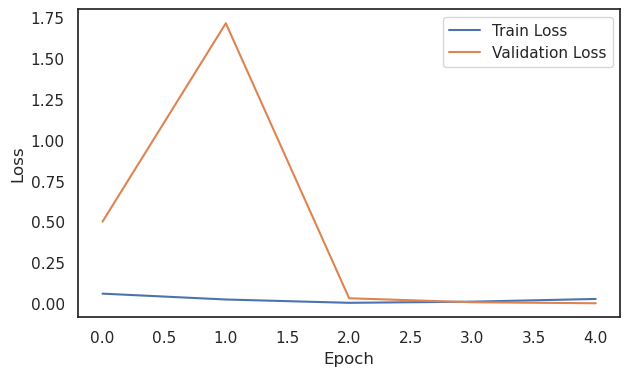

In [70]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7, 4))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

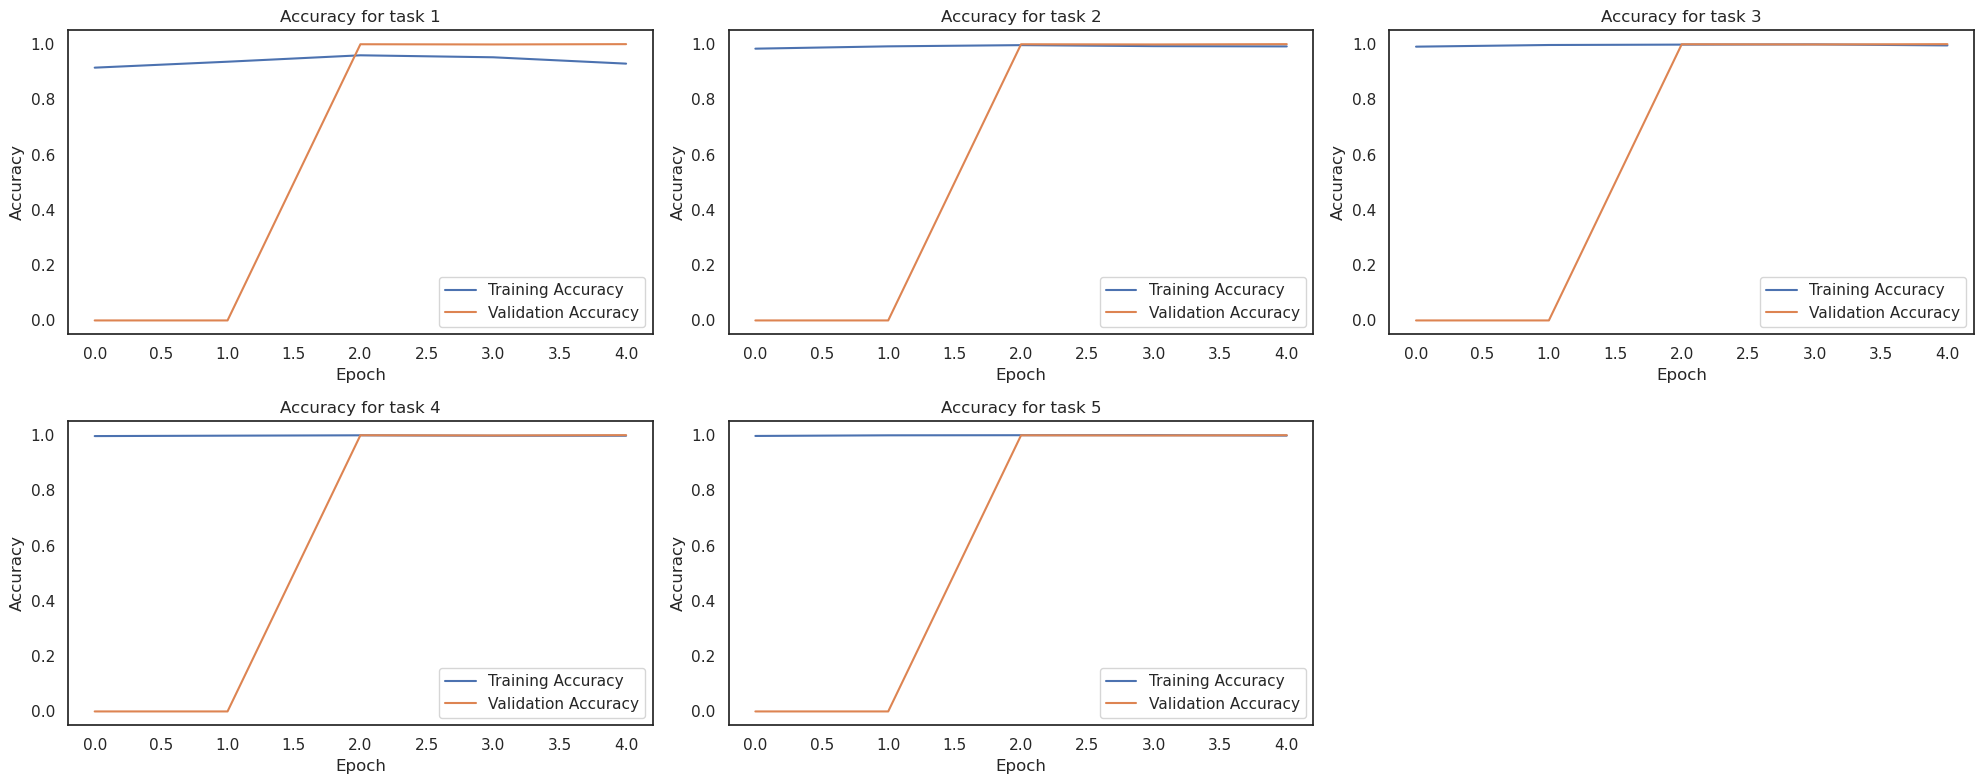

In [67]:
import matplotlib.pyplot as plt

def plot_accuracy(acc_history):
    fig, axes = plt.subplots(2, 3, figsize=[20, 8]) # 2행 3열의 subplot을 생성합니다.

    for i, (train_acc, val_acc) in enumerate(acc_history):
        row = i // 3 # 행의 위치를 계산합니다.
        col = i % 3  # 열의 위치를 계산합니다.
        axes[row, col].plot(train_acc, label="Training Accuracy")
        axes[row, col].plot(val_acc, label="Validation Accuracy")
        axes[row, col].set_title(f"Accuracy for task {i + 1}")
        axes[row, col].set_xlabel("Epoch")
        axes[row, col].set_ylabel("Accuracy")
        axes[row, col].legend()
    
    # 마지막 subplot이 비어있으므로 숨깁니다.
    if len(acc_history) < 6:
        axes[1, 2].axis('off')

    plt.tight_layout() # 각 subplot 사이의 간격을 자동으로 조정합니다.
    plt.show()

plot_accuracy(acc_history)

# Inference

In [71]:
test_df

,image_path,patient_id,series_id,instance_number,width,height
0,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,63706,39279,30,512,512
1,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,50046,24574,30,512,512
2,/kaggle/input/rsna-atd-512x512-png-v2-dataset/...,48843,62825,30,512,512


In [72]:
import torch.nn.functional as F

def mc_proc(pred):
    argmax = np.argmax(pred, axis=1).astype('uint8')
    argmax_tensor = torch.tensor(argmax)  # Assuming argmax is a tensor or array
    one_hot_tensor = F.one_hot(argmax_tensor, num_classes=3)
    one_hot = tf.keras.utils.to_categorical(argmax, num_classes=3)
    return one_hot.astype('uint8')

def sc_proc(pred, thr=0.5):
    proc_pred = (pred > thr).astype('uint8')
    return proc_pred

def post_proc(pred):
    proc_pred = np.empty((pred.shape[0], 2 + 2 + 3*3), dtype=np.uint8)

    # bowel, extravasation
    proc_pred[:, 0] = sc_proc(pred[:, 0])
    proc_pred[:, 1] = 1 - proc_pred[:, 0]
    proc_pred[:, 2] = sc_proc(pred[:, 1])
    proc_pred[:, 3] = 1 - proc_pred[:, 2]
    
    # liver, kidney, sneel
    proc_pred[:, 4:7] = mc_proc(pred[:, 2:5])
    proc_pred[:, 7:10] = mc_proc(pred[:, 5:8])
    proc_pred[:, 10:13] = mc_proc(pred[:, 8:11])

    return proc_pred

def post_proc_v2(pred):
    proc_pred = np.empty((pred.shape[0], 2*2 + 3*3), dtype='float32')

    # bowel, extravasation
    proc_pred[:, 0] = pred[:, 0]
    proc_pred[:, 1] = 1 - proc_pred[:, 0]
    proc_pred[:, 2] = pred[:, 1]
    proc_pred[:, 3] = 1 - proc_pred[:, 2]
    
    # liver, kidney, sneel
    proc_pred[:, 4:7] = pred[:, 2:5]
    proc_pred[:, 7:10] = pred[:, 5:8]
    proc_pred[:, 10:13] = pred[:, 8:11]

    return proc_pred